# Sprint 7: Introduction to Machine Learning #

# Preliminaries #

In [1]:
# Load libraries

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
# Load data

df_behavior = pd.read_csv('/datasets/users_behavior.csv')

The purpose of this project is to train a model to recommend Megaline phone plans based on subscriber behavior. 

# Examine Data #

In [3]:
# Examine the df_behavior dataframe

display(df_behavior.info())
print()
display(df_behavior)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


None

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
...,...,...,...,...,...
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0


In [4]:
# Create a function to examine columns

def histo(df, column, label):
    display(df[column].describe())
    plt.hist(df[column], bins=25)
    plt.xlabel(label)
    plt.ylabel('Number of Observations')
    plt.title(f'Histogram for {label}')
    plt.show()

count    3214.000000
mean       63.038892
std        33.236368
min         0.000000
25%        40.000000
50%        62.000000
75%        82.000000
max       244.000000
Name: calls, dtype: float64

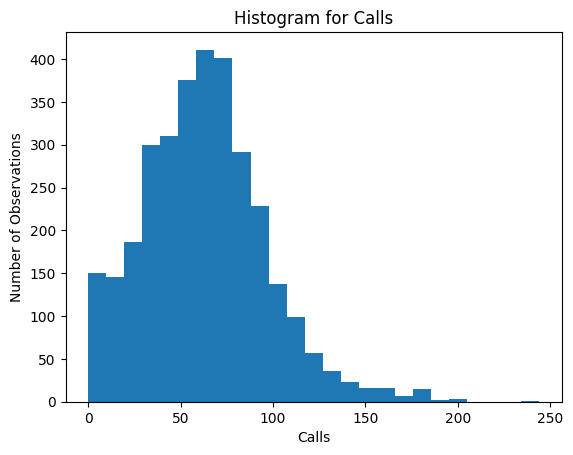

count    3214.000000
mean      438.208787
std       234.569872
min         0.000000
25%       274.575000
50%       430.600000
75%       571.927500
max      1632.060000
Name: minutes, dtype: float64

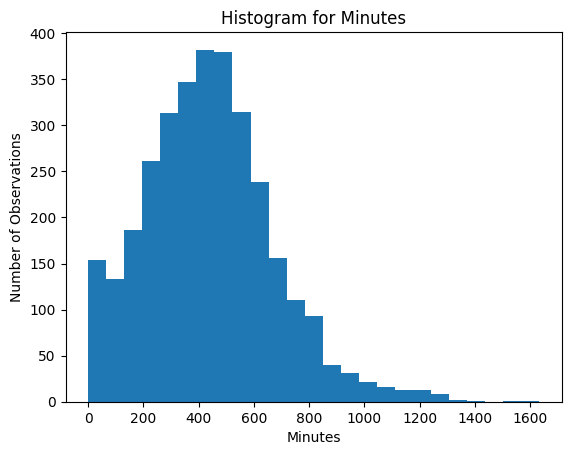

count    3214.000000
mean       38.281269
std        36.148326
min         0.000000
25%         9.000000
50%        30.000000
75%        57.000000
max       224.000000
Name: messages, dtype: float64

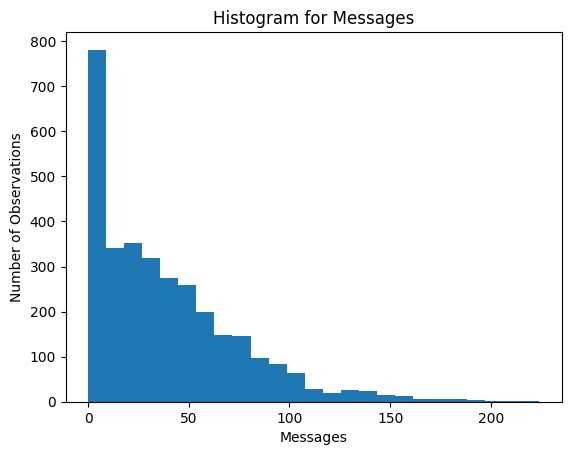

count     3214.000000
mean     17207.673836
std       7570.968246
min          0.000000
25%      12491.902500
50%      16943.235000
75%      21424.700000
max      49745.730000
Name: mb_used, dtype: float64

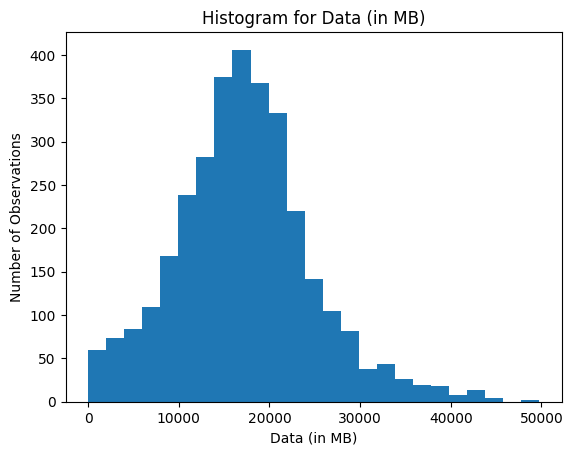

count    3214.000000
mean        0.306472
std         0.461100
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: is_ultra, dtype: float64

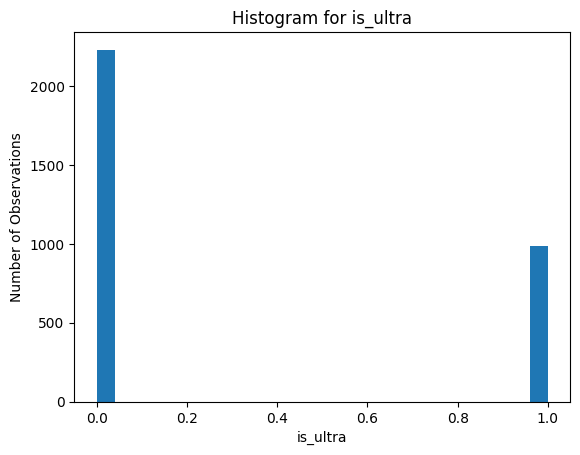

In [5]:
# Examine all colums from df_behavior

histo(df_behavior, 'calls', 'Calls')
histo(df_behavior, 'minutes', 'Minutes')
histo(df_behavior, 'messages', 'Messages')
histo(df_behavior, 'mb_used', 'Data (in MB)')
histo(df_behavior, 'is_ultra', 'is_ultra')


The data look good overall. I found no missing or obviously inappropriate values. I will change the calls and messages columns to an integer data type, but the rest are correct. 

# Prepare the Data #

In [6]:
# Change calls and messages columns to integer data type

def float_to_int(df, column):
    if np.all(df[column] == df[column].astype(int)):
        print(f"Data from the {column} column are equal as float and integer types, so conversion is safe.")
        df[column] = df[column].astype(int)
    else:
        print(f"Data from the {column} column are not equal as float and integer types, so conversion is NOT safe.")

float_to_int(df_behavior, 'calls')
float_to_int(df_behavior, 'messages')
print()
print(df_behavior.info())

Data from the calls column are equal as float and integer types, so conversion is safe.
Data from the messages column are equal as float and integer types, so conversion is safe.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   int64  
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   int64  
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 125.7 KB
None


In [7]:
# Split the data into a training set, a validation set, and a test set

features = df_behavior.drop(['is_ultra'], axis=1)
target = df_behavior['is_ultra']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=.2, random_state=12345)
features_train, features_valid, target_train, target_valid = train_test_split(features_train, target_train, test_size=.25, random_state=12345)

print(f"Training set size: {len(features_train)}, {100*len(features_train)/3214:.0f}%")
print(f"Validation set size: {len(features_valid)}, {100*len(features_valid)/3214:.0f}%")
print(f"Test set size: {len(features_test)}, {100*len(features_test)/3214:.0f}%")

Training set size: 1928, 60%
Validation set size: 643, 20%
Test set size: 643, 20%


I chose the conventional train:validation:test ratio of 3:1:1 or 60%:20%:20% for splitting the data into sets.  

# Analyze/Model Data #

In [8]:
# Find the best fittting decision tree classifier model by varying depth

best_dt_model = None
best_dt_depth = 0
best_dt_result = 0
dt_results = []

for depth in range(1, 51):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predictions_train = model.predict(features_train) 
    predictions_valid = model.predict(features_valid)
    result_train = accuracy_score(target_train, predictions_train)
    result_valid = accuracy_score(target_valid, predictions_valid)
    print(f'model depth = {depth}, training set accuracy = {result_train:.4f}, validation set accuracy = {result_valid:.4f}')
    dt_results.append([depth, result_train, result_valid]) 
    if result_valid > best_dt_result:
        best_dt_depth = depth
        best_dt_model = model
        best_dt_result = result_valid

dt_results = pd.DataFrame(dt_results, columns=['depth', 'result_train', 'result_valid'])

print()
print("Best decision tree model:")
print("Depth:", best_dt_depth)
print(f"Accuracy: {best_dt_result:.4f}")

model depth = 1, training set accuracy = 0.7583, validation set accuracy = 0.7387
model depth = 2, training set accuracy = 0.7920, validation set accuracy = 0.7574
model depth = 3, training set accuracy = 0.8117, validation set accuracy = 0.7652
model depth = 4, training set accuracy = 0.8205, validation set accuracy = 0.7636
model depth = 5, training set accuracy = 0.8273, validation set accuracy = 0.7589
model depth = 6, training set accuracy = 0.8335, validation set accuracy = 0.7574
model depth = 7, training set accuracy = 0.8506, validation set accuracy = 0.7745
model depth = 8, training set accuracy = 0.8662, validation set accuracy = 0.7667
model depth = 9, training set accuracy = 0.8750, validation set accuracy = 0.7621
model depth = 10, training set accuracy = 0.8911, validation set accuracy = 0.7714
model depth = 11, training set accuracy = 0.9025, validation set accuracy = 0.7589
model depth = 12, training set accuracy = 0.9155, validation set accuracy = 0.7558
model depth =

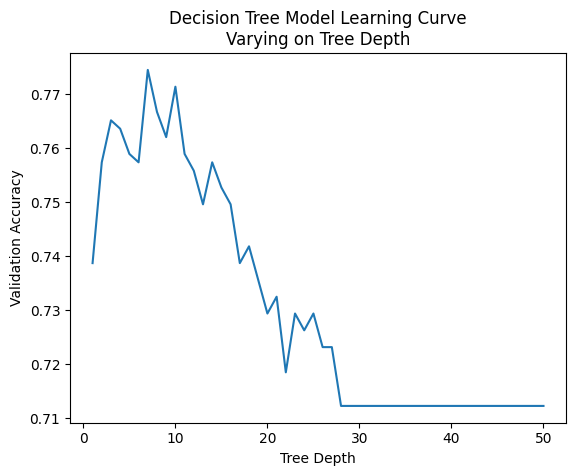

In [9]:
# plot results for decision tree classifiers with varying depth

plt.plot(dt_results['depth'], dt_results['result_valid'])
plt.xlabel('Tree Depth')
plt.ylabel('Validation Accuracy')
plt.title('Decision Tree Model Learning Curve\nVarying on Tree Depth')
plt.show()

The best decision tree classifier model has a depth of 7 and a good accuracy of 0.7745. The plot shows accuracy sharply dropping with greater depth beyond the peak, so this is the best possible model of this kind.

In [10]:
# Find the best fittting random forest classifier model by varying estimators

best_rf_model = None
best_rf_est = 0
best_rf_result = 0
rf_results = []

for est in range(1, 51):
    model = RandomForestClassifier(random_state=12345, n_estimators=est)
    model.fit(features_train, target_train)
    predictions_train = model.predict(features_train) 
    predictions_valid = model.predict(features_valid)
    result_train = accuracy_score(target_train, predictions_train)
    result_valid = accuracy_score(target_valid, predictions_valid)
    print(f'model estimators = {est}, training set accuracy = {result_train:.4f}, validation set accuracy = {result_valid:.4f}')
    rf_results.append([est, result_train, result_valid]) 
    if result_valid > best_rf_result:
        best_rf_est = est
        best_rf_model = model
        best_rf_result = result_valid
        
rf_results = pd.DataFrame(rf_results, columns=['est', 'result_train', 'result_valid'])

print()
print("Best random forest model:")
print("Estimators:", best_rf_est)
print(f"Accuracy: {best_rf_result:.4f}")

model estimators = 1, training set accuracy = 0.9025, validation set accuracy = 0.7030
model estimators = 2, training set accuracy = 0.9103, validation set accuracy = 0.7574
model estimators = 3, training set accuracy = 0.9590, validation set accuracy = 0.7449
model estimators = 4, training set accuracy = 0.9481, validation set accuracy = 0.7652
model estimators = 5, training set accuracy = 0.9710, validation set accuracy = 0.7621
model estimators = 6, training set accuracy = 0.9652, validation set accuracy = 0.7698
model estimators = 7, training set accuracy = 0.9793, validation set accuracy = 0.7714
model estimators = 8, training set accuracy = 0.9720, validation set accuracy = 0.7869
model estimators = 9, training set accuracy = 0.9818, validation set accuracy = 0.7838
model estimators = 10, training set accuracy = 0.9798, validation set accuracy = 0.7885
model estimators = 11, training set accuracy = 0.9881, validation set accuracy = 0.7807
model estimators = 12, training set accur

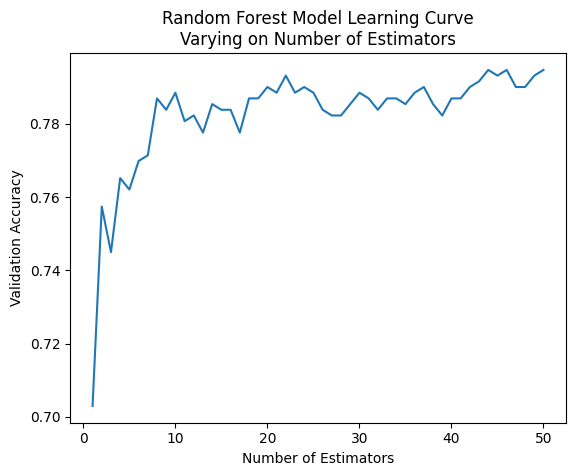

In [11]:
# plot results for random forest classifiers with varying estimators

plt.plot(rf_results['est'], rf_results['result_valid'])
plt.xlabel('Number of Estimators')
plt.ylabel('Validation Accuracy')
plt.title('Random Forest Model Learning Curve\nVarying on Number of Estimators')
plt.show()

The best random forest classifier model I tested has 44 estimators and a great accuracy of 0.7947. I arbitrarily stopped after 50 estimators, but the plot indicates that models with more estimators achieve higher accuracy, so there might be better models of this type. However, accuracy hit something of a plateau after 10 estimators, so further improvement is likely to be small and outweighed by increased complexity. I want to see if a better model can be found by specifying tree depth in addition to estimators.

In [12]:
# Find the best fittting random forest classifier model by varying estimators and depth

best_rf_depth_model = None
best_rf_depth_est = 0
best_rf_depth_depth = 0
best_rf_depth_result = 0
rf_depth_results = []

for est in range(1, 51):
    for depth in range (1, 31):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        predictions_train = model.predict(features_train) 
        predictions_valid = model.predict(features_valid)
        result_train = accuracy_score(target_train, predictions_train)
        result_valid = accuracy_score(target_valid, predictions_valid)
        print(f'model estimators = {est}, depth = {depth}, training set accuracy = {result_train:.4f}, validation set accuracy = {result_valid:.4f}')
        rf_depth_results.append([est, depth, result_train, result_valid]) 
        if result_valid > best_rf_depth_result:
            best_rf_depth_est = est
            best_rf_depth_depth = depth
            best_rf_depth_model = model
            best_rf_depth_result = result_valid

rf_depth_results = pd.DataFrame(rf_depth_results, columns=['est', 'depth', 'result_train', 'result_valid'])
            
print()
print("Best random forest model:")
print("Estimators:", best_rf_depth_est)
print("Depth:", best_rf_depth_depth)
print(f"Accuracy: {best_rf_depth_result:.4f}")

model estimators = 1, depth = 1, training set accuracy = 0.7469, validation set accuracy = 0.7263
model estimators = 1, depth = 2, training set accuracy = 0.7889, validation set accuracy = 0.7574
model estimators = 1, depth = 3, training set accuracy = 0.7910, validation set accuracy = 0.7574
model estimators = 1, depth = 4, training set accuracy = 0.7977, validation set accuracy = 0.7698
model estimators = 1, depth = 5, training set accuracy = 0.8076, validation set accuracy = 0.7714
model estimators = 1, depth = 6, training set accuracy = 0.8273, validation set accuracy = 0.7667
model estimators = 1, depth = 7, training set accuracy = 0.8397, validation set accuracy = 0.7807
model estimators = 1, depth = 8, training set accuracy = 0.8418, validation set accuracy = 0.7745
model estimators = 1, depth = 9, training set accuracy = 0.8563, validation set accuracy = 0.7760
model estimators = 1, depth = 10, training set accuracy = 0.8631, validation set accuracy = 0.7605
model estimators = 

model estimators = 3, depth = 28, training set accuracy = 0.9590, validation set accuracy = 0.7449
model estimators = 3, depth = 29, training set accuracy = 0.9590, validation set accuracy = 0.7449
model estimators = 3, depth = 30, training set accuracy = 0.9590, validation set accuracy = 0.7449
model estimators = 4, depth = 1, training set accuracy = 0.7469, validation set accuracy = 0.7263
model estimators = 4, depth = 2, training set accuracy = 0.7962, validation set accuracy = 0.7621
model estimators = 4, depth = 3, training set accuracy = 0.7951, validation set accuracy = 0.7605
model estimators = 4, depth = 4, training set accuracy = 0.8034, validation set accuracy = 0.7652
model estimators = 4, depth = 5, training set accuracy = 0.8252, validation set accuracy = 0.7621
model estimators = 4, depth = 6, training set accuracy = 0.8408, validation set accuracy = 0.7776
model estimators = 4, depth = 7, training set accuracy = 0.8558, validation set accuracy = 0.7776
model estimators 

model estimators = 6, depth = 23, training set accuracy = 0.9673, validation set accuracy = 0.7698
model estimators = 6, depth = 24, training set accuracy = 0.9658, validation set accuracy = 0.7714
model estimators = 6, depth = 25, training set accuracy = 0.9658, validation set accuracy = 0.7745
model estimators = 6, depth = 26, training set accuracy = 0.9652, validation set accuracy = 0.7698
model estimators = 6, depth = 27, training set accuracy = 0.9652, validation set accuracy = 0.7698
model estimators = 6, depth = 28, training set accuracy = 0.9652, validation set accuracy = 0.7698
model estimators = 6, depth = 29, training set accuracy = 0.9652, validation set accuracy = 0.7698
model estimators = 6, depth = 30, training set accuracy = 0.9652, validation set accuracy = 0.7698
model estimators = 7, depth = 1, training set accuracy = 0.7459, validation set accuracy = 0.7294
model estimators = 7, depth = 2, training set accuracy = 0.7573, validation set accuracy = 0.7372
model estima

model estimators = 9, depth = 20, training set accuracy = 0.9746, validation set accuracy = 0.7776
model estimators = 9, depth = 21, training set accuracy = 0.9772, validation set accuracy = 0.7807
model estimators = 9, depth = 22, training set accuracy = 0.9808, validation set accuracy = 0.7807
model estimators = 9, depth = 23, training set accuracy = 0.9824, validation set accuracy = 0.7776
model estimators = 9, depth = 24, training set accuracy = 0.9818, validation set accuracy = 0.7838
model estimators = 9, depth = 25, training set accuracy = 0.9834, validation set accuracy = 0.7854
model estimators = 9, depth = 26, training set accuracy = 0.9818, validation set accuracy = 0.7838
model estimators = 9, depth = 27, training set accuracy = 0.9818, validation set accuracy = 0.7838
model estimators = 9, depth = 28, training set accuracy = 0.9818, validation set accuracy = 0.7838
model estimators = 9, depth = 29, training set accuracy = 0.9818, validation set accuracy = 0.7838
model esti

model estimators = 12, depth = 15, training set accuracy = 0.9372, validation set accuracy = 0.7869
model estimators = 12, depth = 16, training set accuracy = 0.9554, validation set accuracy = 0.7854
model estimators = 12, depth = 17, training set accuracy = 0.9637, validation set accuracy = 0.7838
model estimators = 12, depth = 18, training set accuracy = 0.9621, validation set accuracy = 0.7885
model estimators = 12, depth = 19, training set accuracy = 0.9730, validation set accuracy = 0.7869
model estimators = 12, depth = 20, training set accuracy = 0.9803, validation set accuracy = 0.7869
model estimators = 12, depth = 21, training set accuracy = 0.9798, validation set accuracy = 0.7854
model estimators = 12, depth = 22, training set accuracy = 0.9829, validation set accuracy = 0.7885
model estimators = 12, depth = 23, training set accuracy = 0.9839, validation set accuracy = 0.7807
model estimators = 12, depth = 24, training set accuracy = 0.9834, validation set accuracy = 0.7885


model estimators = 15, depth = 9, training set accuracy = 0.8791, validation set accuracy = 0.7932
model estimators = 15, depth = 10, training set accuracy = 0.8880, validation set accuracy = 0.7916
model estimators = 15, depth = 11, training set accuracy = 0.9004, validation set accuracy = 0.7994
model estimators = 15, depth = 12, training set accuracy = 0.9191, validation set accuracy = 0.7900
model estimators = 15, depth = 13, training set accuracy = 0.9238, validation set accuracy = 0.7947
model estimators = 15, depth = 14, training set accuracy = 0.9331, validation set accuracy = 0.7823
model estimators = 15, depth = 15, training set accuracy = 0.9429, validation set accuracy = 0.7885
model estimators = 15, depth = 16, training set accuracy = 0.9507, validation set accuracy = 0.7869
model estimators = 15, depth = 17, training set accuracy = 0.9611, validation set accuracy = 0.7885
model estimators = 15, depth = 18, training set accuracy = 0.9647, validation set accuracy = 0.7885
m

model estimators = 18, depth = 5, training set accuracy = 0.8314, validation set accuracy = 0.7760
model estimators = 18, depth = 6, training set accuracy = 0.8454, validation set accuracy = 0.7838
model estimators = 18, depth = 7, training set accuracy = 0.8594, validation set accuracy = 0.7869
model estimators = 18, depth = 8, training set accuracy = 0.8683, validation set accuracy = 0.7854
model estimators = 18, depth = 9, training set accuracy = 0.8812, validation set accuracy = 0.7947
model estimators = 18, depth = 10, training set accuracy = 0.8906, validation set accuracy = 0.7916
model estimators = 18, depth = 11, training set accuracy = 0.8973, validation set accuracy = 0.7932
model estimators = 18, depth = 12, training set accuracy = 0.9217, validation set accuracy = 0.7932
model estimators = 18, depth = 13, training set accuracy = 0.9238, validation set accuracy = 0.7978
model estimators = 18, depth = 14, training set accuracy = 0.9341, validation set accuracy = 0.7869
model

model estimators = 20, depth = 30, training set accuracy = 0.9948, validation set accuracy = 0.7900
model estimators = 21, depth = 1, training set accuracy = 0.7505, validation set accuracy = 0.7309
model estimators = 21, depth = 2, training set accuracy = 0.7920, validation set accuracy = 0.7621
model estimators = 21, depth = 3, training set accuracy = 0.8122, validation set accuracy = 0.7729
model estimators = 21, depth = 4, training set accuracy = 0.8226, validation set accuracy = 0.7760
model estimators = 21, depth = 5, training set accuracy = 0.8356, validation set accuracy = 0.7838
model estimators = 21, depth = 6, training set accuracy = 0.8460, validation set accuracy = 0.7838
model estimators = 21, depth = 7, training set accuracy = 0.8610, validation set accuracy = 0.7885
model estimators = 21, depth = 8, training set accuracy = 0.8703, validation set accuracy = 0.7854
model estimators = 21, depth = 9, training set accuracy = 0.8771, validation set accuracy = 0.7916
model est

model estimators = 23, depth = 25, training set accuracy = 0.9959, validation set accuracy = 0.7947
model estimators = 23, depth = 26, training set accuracy = 0.9964, validation set accuracy = 0.7885
model estimators = 23, depth = 27, training set accuracy = 0.9974, validation set accuracy = 0.7885
model estimators = 23, depth = 28, training set accuracy = 0.9974, validation set accuracy = 0.7885
model estimators = 23, depth = 29, training set accuracy = 0.9974, validation set accuracy = 0.7885
model estimators = 23, depth = 30, training set accuracy = 0.9974, validation set accuracy = 0.7885
model estimators = 24, depth = 1, training set accuracy = 0.7495, validation set accuracy = 0.7294
model estimators = 24, depth = 2, training set accuracy = 0.7920, validation set accuracy = 0.7621
model estimators = 24, depth = 3, training set accuracy = 0.8117, validation set accuracy = 0.7698
model estimators = 24, depth = 4, training set accuracy = 0.8226, validation set accuracy = 0.7745
mode

model estimators = 26, depth = 19, training set accuracy = 0.9808, validation set accuracy = 0.7854
model estimators = 26, depth = 20, training set accuracy = 0.9912, validation set accuracy = 0.7838
model estimators = 26, depth = 21, training set accuracy = 0.9933, validation set accuracy = 0.7838
model estimators = 26, depth = 22, training set accuracy = 0.9943, validation set accuracy = 0.7823
model estimators = 26, depth = 23, training set accuracy = 0.9964, validation set accuracy = 0.7885
model estimators = 26, depth = 24, training set accuracy = 0.9969, validation set accuracy = 0.7900
model estimators = 26, depth = 25, training set accuracy = 0.9959, validation set accuracy = 0.7885
model estimators = 26, depth = 26, training set accuracy = 0.9959, validation set accuracy = 0.7885
model estimators = 26, depth = 27, training set accuracy = 0.9964, validation set accuracy = 0.7900
model estimators = 26, depth = 28, training set accuracy = 0.9964, validation set accuracy = 0.7838


model estimators = 29, depth = 14, training set accuracy = 0.9352, validation set accuracy = 0.7932
model estimators = 29, depth = 15, training set accuracy = 0.9492, validation set accuracy = 0.7932
model estimators = 29, depth = 16, training set accuracy = 0.9601, validation set accuracy = 0.7916
model estimators = 29, depth = 17, training set accuracy = 0.9678, validation set accuracy = 0.7823
model estimators = 29, depth = 18, training set accuracy = 0.9735, validation set accuracy = 0.7916
model estimators = 29, depth = 19, training set accuracy = 0.9834, validation set accuracy = 0.7854
model estimators = 29, depth = 20, training set accuracy = 0.9917, validation set accuracy = 0.7838
model estimators = 29, depth = 21, training set accuracy = 0.9948, validation set accuracy = 0.7776
model estimators = 29, depth = 22, training set accuracy = 0.9969, validation set accuracy = 0.7838
model estimators = 29, depth = 23, training set accuracy = 0.9974, validation set accuracy = 0.7885


model estimators = 32, depth = 7, training set accuracy = 0.8626, validation set accuracy = 0.7869
model estimators = 32, depth = 8, training set accuracy = 0.8709, validation set accuracy = 0.7854
model estimators = 32, depth = 9, training set accuracy = 0.8776, validation set accuracy = 0.7916
model estimators = 32, depth = 10, training set accuracy = 0.8916, validation set accuracy = 0.7916
model estimators = 32, depth = 11, training set accuracy = 0.9009, validation set accuracy = 0.7885
model estimators = 32, depth = 12, training set accuracy = 0.9155, validation set accuracy = 0.7916
model estimators = 32, depth = 13, training set accuracy = 0.9238, validation set accuracy = 0.7963
model estimators = 32, depth = 14, training set accuracy = 0.9321, validation set accuracy = 0.7900
model estimators = 32, depth = 15, training set accuracy = 0.9466, validation set accuracy = 0.7963
model estimators = 32, depth = 16, training set accuracy = 0.9580, validation set accuracy = 0.7947
mod

model estimators = 35, depth = 2, training set accuracy = 0.7910, validation set accuracy = 0.7621
model estimators = 35, depth = 3, training set accuracy = 0.8128, validation set accuracy = 0.7683
model estimators = 35, depth = 4, training set accuracy = 0.8216, validation set accuracy = 0.7776
model estimators = 35, depth = 5, training set accuracy = 0.8304, validation set accuracy = 0.7807
model estimators = 35, depth = 6, training set accuracy = 0.8485, validation set accuracy = 0.7823
model estimators = 35, depth = 7, training set accuracy = 0.8620, validation set accuracy = 0.7838
model estimators = 35, depth = 8, training set accuracy = 0.8698, validation set accuracy = 0.7854
model estimators = 35, depth = 9, training set accuracy = 0.8786, validation set accuracy = 0.7900
model estimators = 35, depth = 10, training set accuracy = 0.8937, validation set accuracy = 0.7978
model estimators = 35, depth = 11, training set accuracy = 0.9020, validation set accuracy = 0.7869
model es

model estimators = 37, depth = 26, training set accuracy = 0.9969, validation set accuracy = 0.7854
model estimators = 37, depth = 27, training set accuracy = 0.9969, validation set accuracy = 0.7916
model estimators = 37, depth = 28, training set accuracy = 0.9969, validation set accuracy = 0.7900
model estimators = 37, depth = 29, training set accuracy = 0.9974, validation set accuracy = 0.7900
model estimators = 37, depth = 30, training set accuracy = 0.9974, validation set accuracy = 0.7900
model estimators = 38, depth = 1, training set accuracy = 0.7593, validation set accuracy = 0.7387
model estimators = 38, depth = 2, training set accuracy = 0.7920, validation set accuracy = 0.7621
model estimators = 38, depth = 3, training set accuracy = 0.8117, validation set accuracy = 0.7683
model estimators = 38, depth = 4, training set accuracy = 0.8205, validation set accuracy = 0.7792
model estimators = 38, depth = 5, training set accuracy = 0.8325, validation set accuracy = 0.7807
model

model estimators = 40, depth = 20, training set accuracy = 0.9922, validation set accuracy = 0.7900
model estimators = 40, depth = 21, training set accuracy = 0.9948, validation set accuracy = 0.7823
model estimators = 40, depth = 22, training set accuracy = 0.9948, validation set accuracy = 0.7823
model estimators = 40, depth = 23, training set accuracy = 0.9959, validation set accuracy = 0.7900
model estimators = 40, depth = 24, training set accuracy = 0.9964, validation set accuracy = 0.7885
model estimators = 40, depth = 25, training set accuracy = 0.9964, validation set accuracy = 0.7854
model estimators = 40, depth = 26, training set accuracy = 0.9964, validation set accuracy = 0.7869
model estimators = 40, depth = 27, training set accuracy = 0.9964, validation set accuracy = 0.7900
model estimators = 40, depth = 28, training set accuracy = 0.9964, validation set accuracy = 0.7869
model estimators = 40, depth = 29, training set accuracy = 0.9964, validation set accuracy = 0.7869


model estimators = 43, depth = 14, training set accuracy = 0.9357, validation set accuracy = 0.7963
model estimators = 43, depth = 15, training set accuracy = 0.9507, validation set accuracy = 0.7978
model estimators = 43, depth = 16, training set accuracy = 0.9611, validation set accuracy = 0.7947
model estimators = 43, depth = 17, training set accuracy = 0.9684, validation set accuracy = 0.7885
model estimators = 43, depth = 18, training set accuracy = 0.9751, validation set accuracy = 0.8009
model estimators = 43, depth = 19, training set accuracy = 0.9839, validation set accuracy = 0.7869
model estimators = 43, depth = 20, training set accuracy = 0.9927, validation set accuracy = 0.7869
model estimators = 43, depth = 21, training set accuracy = 0.9948, validation set accuracy = 0.7900
model estimators = 43, depth = 22, training set accuracy = 0.9964, validation set accuracy = 0.7854
model estimators = 43, depth = 23, training set accuracy = 0.9979, validation set accuracy = 0.7932


model estimators = 46, depth = 7, training set accuracy = 0.8631, validation set accuracy = 0.7869
model estimators = 46, depth = 8, training set accuracy = 0.8693, validation set accuracy = 0.7869
model estimators = 46, depth = 9, training set accuracy = 0.8812, validation set accuracy = 0.7900
model estimators = 46, depth = 10, training set accuracy = 0.8947, validation set accuracy = 0.7963
model estimators = 46, depth = 11, training set accuracy = 0.9015, validation set accuracy = 0.7947
model estimators = 46, depth = 12, training set accuracy = 0.9165, validation set accuracy = 0.7963
model estimators = 46, depth = 13, training set accuracy = 0.9232, validation set accuracy = 0.7932
model estimators = 46, depth = 14, training set accuracy = 0.9341, validation set accuracy = 0.7932
model estimators = 46, depth = 15, training set accuracy = 0.9507, validation set accuracy = 0.7963
model estimators = 46, depth = 16, training set accuracy = 0.9595, validation set accuracy = 0.7947
mod

model estimators = 49, depth = 1, training set accuracy = 0.7650, validation set accuracy = 0.7465
model estimators = 49, depth = 2, training set accuracy = 0.7905, validation set accuracy = 0.7605
model estimators = 49, depth = 3, training set accuracy = 0.8159, validation set accuracy = 0.7729
model estimators = 49, depth = 4, training set accuracy = 0.8211, validation set accuracy = 0.7745
model estimators = 49, depth = 5, training set accuracy = 0.8330, validation set accuracy = 0.7792
model estimators = 49, depth = 6, training set accuracy = 0.8465, validation set accuracy = 0.7807
model estimators = 49, depth = 7, training set accuracy = 0.8631, validation set accuracy = 0.7854
model estimators = 49, depth = 8, training set accuracy = 0.8703, validation set accuracy = 0.7869
model estimators = 49, depth = 9, training set accuracy = 0.8797, validation set accuracy = 0.7885
model estimators = 49, depth = 10, training set accuracy = 0.8947, validation set accuracy = 0.7963
model est

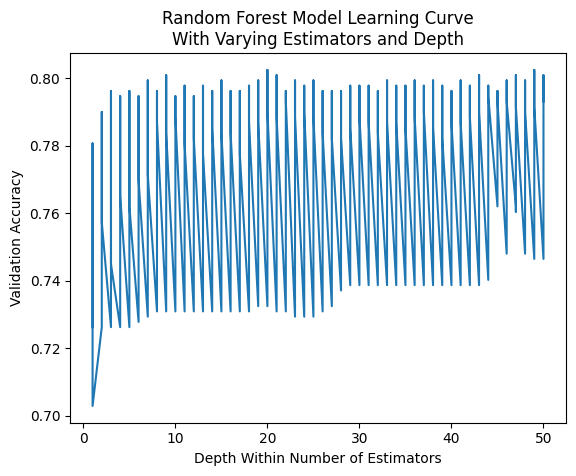

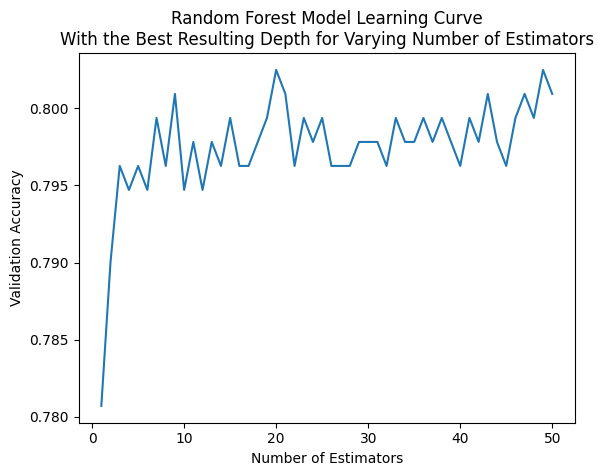

In [13]:
# plot results for random forest classifiers with varying estimators and depth

plt.plot(rf_depth_results['est'], rf_depth_results['result_valid'])
plt.xlabel('Depth Within Number of Estimators')
plt.ylabel('Validation Accuracy')
plt.title('Random Forest Model Learning Curve\nWith Varying Estimators and Depth')
plt.show()
print()

rf_depth_max = pd.DataFrame(rf_depth_results.groupby('est')['result_valid'].max()).reset_index()

plt.plot(rf_depth_max['est'], rf_depth_max['result_valid'])
plt.xlabel('Number of Estimators')
plt.ylabel('Validation Accuracy')
plt.title('Random Forest Model Learning Curve\nWith the Best Resulting Depth for Varying Number of Estimators')
plt.show()

The best random forest classifier model I tested this round has 20 estimators, a depth of 15, and the best accuracy yet with 0.8025. I arbitrarily stopped after 50 estimators and depth of 30, but the plot indicates that models with more estimators achieve higher accuracy, so there might be better models of this type. However, accuracy hit something of a plateau after 3 estimators and a depth of 9, so further improvement is likely to be small and outweighed by increased complexity.

In [14]:
# Train a logistic regression model

lr_model = LogisticRegression(random_state=12345, solver='liblinear')
lr_model.fit(features_train, target_train)
predictions_train = lr_model.predict(features_train) 
predictions_valid = lr_model.predict(features_valid)
lr_result_train = accuracy_score(target_train, predictions_train)
lr_result_valid = accuracy_score(target_valid, predictions_valid)

print()
print("Logistic regression model:")
print(f"Training set accuracy: {lr_result_train:.4f}")
print(f"Validation set accuracy: {lr_result_valid:.4f}")


Logistic regression model:
Training set accuracy: 0.7422
Validation set accuracy: 0.7294


The logistic regression model has a relatively low acuracy of 0.7294, placing it well below the decision tree and random forest classifiers. 

In [15]:
# Summarize validation accuracy

print("Validation Accuracy of the Best Models for Predicting Megaline Plans from Subscriber Behavior")
print(f"Decision Tree (depth = {best_dt_depth}): {best_dt_result:.4f}")
print(f"Random Forest (estimators = {best_rf_est}): {best_rf_result:.4f}")
print(f"Random Forest (estimators = {best_rf_depth_est}, depth = {best_rf_depth_depth}): {best_rf_depth_result:.4f}")
print(f"Logistic Regression: {lr_result_valid:.4f}")

Validation Accuracy of the Best Models for Predicting Megaline Plans from Subscriber Behavior
Decision Tree (depth = 7): 0.7745
Random Forest (estimators = 44): 0.7947
Random Forest (estimators = 20, depth = 15): 0.8025
Logistic Regression: 0.7294


The best model according to accuracy on the validation set is the random forest classifier with 20 estimators and depth 15 (accuracy = 0.8025). 

# Test Models #

In [16]:
# Retrain models with the combined training and validation data

features_combo = pd.concat([features_train, features_valid], ignore_index=True)
target_combo = pd.concat([target_train, target_valid], ignore_index=True)

final_dt_model = best_dt_model.fit(features_combo, target_combo)
final_rf_model = best_rf_model.fit(features_combo, target_combo)
final_rf_depth_model = best_rf_depth_model.fit(features_combo, target_combo)
final_lr_model = lr_model.fit(features_combo, target_combo)

In [17]:
# Test final models with the test data set

dt_test_score = accuracy_score(target_test, final_dt_model.predict(features_test))
rf_test_score = accuracy_score(target_test, final_rf_model.predict(features_test))
rf_depth_test_score = accuracy_score(target_test, final_rf_depth_model.predict(features_test))
lr_test_score = accuracy_score(target_test, final_lr_model.predict(features_test))

print("Test Accuracy of the Best Models for Predicting Megaline Plans from Subscriber Behavior")
print(f"Decision Tree (depth = {best_dt_depth}): {dt_test_score:.4f}")
print(f"Random Forest (estimators = {best_rf_est}): {rf_test_score:.4f}")
print(f"Random Forest (estimators = {best_rf_depth_est}, depth = {best_rf_depth_depth}): {rf_depth_test_score:.4f}")
print(f"Logistic Regression: {lr_test_score:.4f}")

Test Accuracy of the Best Models for Predicting Megaline Plans from Subscriber Behavior
Decision Tree (depth = 7): 0.7792
Random Forest (estimators = 44): 0.7792
Random Forest (estimators = 20, depth = 15): 0.7838
Logistic Regression: 0.7030


In [18]:
# Sanity check the model by comparing it to a random one

rng = np.random.default_rng(seed=12345)
random_test_score = accuracy_score(target_test, rng.choice([0, 1], size=len(features_test)))
print(f"Random model accuracy: {random_test_score:.4f}")

Random model accuracy: 0.5117


The best model according to accuracy on the test set is the random forest classifier with 20 estimators and depth 15 (accuracy = 0.7838). The decision tree and both random forest models surpass the accuracy threshold of 0.75 but the logistic regression model does not (accuracy = 0.7030). The accuracy of those three adequate models is quite close, clustering around 0.78, to the point that none is markedly superior to the others. 

As a sanity check, it is worth noting that a classifier model randomly predicting a dichotomous outcome could expect an accuracy rate around 50%. When I tested such a model - randomly selecting between values of 0 and 1 - against the test set, its accuracy was 0.5117 as expected. All of the other models I tested easily beat chance, which is a good sign. 

# General Discussion #

The goal of this project was to recommend Megaline phone plans to subscribers with legacy plans based on their behavior. I trained and tested decision tree classifier, random forest classifier, and logistic regression models. The best model was a random forest classifier with 20 estimators and depth 15. It correctly classified 78% of Megaline plans in the test data set, better than the other models and far superior than would be expected by chance. That model should be satisfactory for the purpose of recommending plans to users. 